In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

# Check for GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU detected. Falling back to CPU.")

GPU Detected: NVIDIA GeForce RTX 2060


1) --- DATA PREPROCESSING ---

In [2]:
# Import raw csv data
df = pd.read_csv("bank-additional-full2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Drop duplicate rows
initial_row = len(df)
print("Initial rows:", initial_row)
df.drop_duplicates(inplace=True)
print("Duplicate row dropped:",initial_row-len(df))

Initial rows: 41188
Duplicate row dropped: 12


In [5]:
# Drop duration column
# This is because you dont know call duration before you make a call hence not dropping this will cause data leakage
df.drop(columns=['duration'],inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             40846 non-null  object 
 2   marital         41096 non-null  object 
 3   education       39446 non-null  object 
 4   default         32580 non-null  object 
 5   housing         40186 non-null  object 
 6   loan            40186 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  campaign        41176 non-null  int64  
 11  pdays           41176 non-null  int64  
 12  previous        41176 non-null  int64  
 13  poutcome        41176 non-null  object 
 14  emp.var.rate    41176 non-null  float64
 15  cons.price.idx  41176 non-null  float64
 16  cons.conf.idx   41176 non-null  float64
 17  euribor3m       41176 non-null  floa

In [7]:
# This shows exactly which columns are broken
print("\n--- Missing Values Count ---")
print(df.isnull().sum()[df.isnull().sum() > 0])


--- Missing Values Count ---
job           330
marital        80
education    1730
default      8596
housing       990
loan          990
dtype: int64


In [8]:
# Defining the input and output columns, X (input), y (output)
X = df.drop(columns=['y'])
y = df['y']

In [9]:
# Check class imbalance
print(y.value_counts(normalize=True))

# From the output, the class is really imbalance. We will need the test data to have the same imbalance.

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64


In [10]:
# Target encode first
y = y.map({'yes':1,'no':0})

# Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
y_train.values

array([0, 1, 0, ..., 0, 0, 0], shape=(32940,))

In [12]:
# Check class imbalance
print(y_test.value_counts(normalize=True))

# From the output, the test class has the same imbalance as the original class hence it will be a fair test.

y
0    0.887324
1    0.112676
Name: proportion, dtype: float64


In [13]:
# Identifying numerical columns and categorical columns for imputing missing values
num_cols = X_train.select_dtypes(include=['float64','int64']).columns
print("numeric cols:",num_cols)

cat_cols = X_train.select_dtypes(include=['object']).columns
print("Categorical cols:",cat_cols)

print("total cols:",len(num_cols)+len(cat_cols)) # Should be 19 cols total

numeric cols: Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
Categorical cols: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')
total cols: 19


In [14]:
# --- Defining pipelines for numerical and categorical data preprocessing ---

# Numerical pipeline (fill mssing with mean)
num_pipeline = Pipeline(
    [('imputer',SimpleImputer(strategy='mean')),
     ('scaler',StandardScaler())
     ])

# Categorical Pipeline (One-Hot Encoding)
cat_pipeline = Pipeline(
    [
        ('imputer',SimpleImputer(strategy='constant',fill_value='unknown')),
        ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]
)

# Combine into one preprocessor
preprocessor = ColumnTransformer(
    [
        ('num',num_pipeline,num_cols),
        ('cat',cat_pipeline, cat_cols)
    ]
)

# Next, we fit learn pattern ONLY ON X_TRAIN (training input)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) #Apply the pattern to test

# Convert to pytorch float32 tensors
# The 80% train set
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# The 20% test set
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

print('Original Columns:',X_train.shape[1])
print("New Input Features (due to One-Hot):", X_train_tensor.shape[1])

Original Columns: 19
New Input Features (due to One-Hot): 62


This part now is an optional part of saving the test set

In [15]:
# I'm exporting the test data (X_test and y_test) to be used as UNSEEN raw (unprocessed) test dataset
test_set_backup = X_test.copy()
test_set_backup['y'] = y_test
test_set_backup

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
8490,35,services,married,high.school,NaN,no,no,telephone,jun,wed,14,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0
40844,30,student,single,professional.course,no,yes,no,cellular,sep,tue,2,6,1,success,-1.1,94.199,-37.5,0.880,4963.6,1
35681,37,self-employed,single,basic.4y,no,yes,no,cellular,may,mon,3,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1,0
35994,31,blue-collar,single,professional.course,no,no,no,cellular,may,tue,2,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,0
21961,31,technician,married,university.degree,no,NaN,NaN,cellular,aug,wed,2,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16062,30,blue-collar,divorced,basic.9y,no,yes,no,cellular,jul,tue,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
23700,60,admin.,married,basic.9y,no,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,0
34189,21,student,single,high.school,no,no,no,cellular,may,wed,3,999,1,failure,-1.8,92.893,-46.2,1.281,5099.1,0
1963,38,technician,single,professional.course,no,yes,no,telephone,may,fri,3,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0


In [16]:
# Save the test set as a backup as unseen data
test_set_backup.to_csv('test_set_unseen.csv',index=False)

In [17]:
# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [18]:
# Save Train data just in case
train_set_backup = X_train.copy()
train_set_backup['y'] = y_train
train_set_backup.to_csv('train_set_used.csv', index=False)

2. --- DATA LOADERS ---

In [19]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [20]:
# Preparing Data Loaders
# Wrap Tensors into dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [21]:
# Create Loaders
# shuffle=True is critical so that model doesnt memorize the order
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test loader
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

print("Train Loader batches:", len(train_loader))
print("Test Loader batches:",  len(test_loader))

Train Loader batches: 515
Test Loader batches: 9


3. --- BUILDING THE NEURAL NETWORK ---

In [22]:
class BankModel(nn.Module):
    def __init__(self,input_dim):
        super(BankModel, self).__init__()

        # Lets revise some Python OOP concept here, shall we?
        # When we declared self.layer1 for example, it created a new object on top of the nn.Linear()
        # which is an instance of nn.Module. This means layer1 inherits all the method of nn.Module
        # including the hidden __call__ method. Even though the declaration of layer1 itself isnt
        # a function. The inherited __call__ method enable it(layer1 object build ontop of nn.Module)
        # to receive a parameter (in later cases during the forward fx, which is x)

        # Input Layer
        self.layer1 = nn.Linear(input_dim, 32) #Input dim -> 32 output
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # 30% chance of dropping a node to prevent overfitting

        # Hidden Layer
        self.layer2 = nn.Linear(32, 16) #32 input -> 32 output
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # Output Layer
        self.output_layer = nn.Linear(16,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # Pass data through input layer
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # Pass data through hidden layer
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Pass data through Output layer
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x


In [23]:
model = BankModel(input_dim=X_test_tensor.shape[1])
model.to(device)

print("Model Architecture Created:")
print(model)

Model Architecture Created:
BankModel(
  (layer1): Linear(in_features=62, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


4. --- THE TRAINING LOOP ---

In [24]:
# Binary Cross Entropy Loss (Standard for Yes/No problems)
# We use 'weight' to punish the model more for missing a "Yes" (since they are rare)
# roughly 8x weight because 1:8 imbalance.
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward Pass
        y_pred = model(X_batch)

        # Loss Calculation
        loss = criterion(y_pred, y_batch.view(-1,1))

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete!")

Epoch 1/20 | Loss: 0.3351
Epoch 2/20 | Loss: 0.2954
Epoch 3/20 | Loss: 0.2909
Epoch 4/20 | Loss: 0.2888
Epoch 5/20 | Loss: 0.2879
Epoch 6/20 | Loss: 0.2859
Epoch 7/20 | Loss: 0.2855
Epoch 8/20 | Loss: 0.2858
Epoch 9/20 | Loss: 0.2830
Epoch 10/20 | Loss: 0.2820
Epoch 11/20 | Loss: 0.2807
Epoch 12/20 | Loss: 0.2812
Epoch 13/20 | Loss: 0.2809
Epoch 14/20 | Loss: 0.2791
Epoch 15/20 | Loss: 0.2779
Epoch 16/20 | Loss: 0.2786
Epoch 17/20 | Loss: 0.2776
Epoch 18/20 | Loss: 0.2789
Epoch 19/20 | Loss: 0.2768
Epoch 20/20 | Loss: 0.2764
Training Complete!


5. --- EVALUATION ---

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

Final Test Accuracy: 86.56%


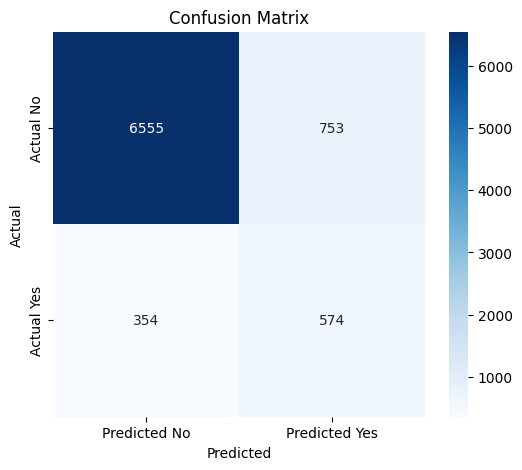

--- Classification Report ---
              precision    recall  f1-score   support

          No       0.95      0.90      0.92      7308
         Yes       0.43      0.62      0.51       928

    accuracy                           0.87      8236
   macro avg       0.69      0.76      0.72      8236
weighted avg       0.89      0.87      0.88      8236



In [26]:
# Switch to evaluation mode
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Predict
        outputs = model(X_batch)
        predicted = (outputs > 0.15).float()

        # Move back to cpu
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate Metrics
acc = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Full Report
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['No','Yes']))

Accuracy: Anything above 85% is acceptable.

Recall: above 50-60%

F1-Score: This combines both. A good F1 score for the "Yes" class in this difficult dataset is usually around 0.50 to 0.60.

In [27]:
# To save comparison csv (y_pred vs y_true)
comparison_df = pd.DataFrame({
    'Predicted Value': y_pred,
    'True Value': y_true
})

comparison_df['correct?'] = comparison_df['Predicted Value'] == comparison_df['True Value']
is_false = (comparison_df['correct?'] == 'False')

print(comparison_df.head(10))

# Export to CSV
comparison_df.to_csv("model_predictions_comparison.csv", index=False)

  Predicted Value  True Value  correct?
0           [0.0]         0.0      True
1           [1.0]         1.0      True
2           [0.0]         0.0      True
3           [0.0]         0.0      True
4           [0.0]         0.0      True
5           [0.0]         0.0      True
6           [0.0]         0.0      True
7           [0.0]         0.0      True
8           [0.0]         0.0      True
9           [0.0]         0.0      True


In [28]:
# Save model
torch.save(model.state_dict(), 'model.pth')